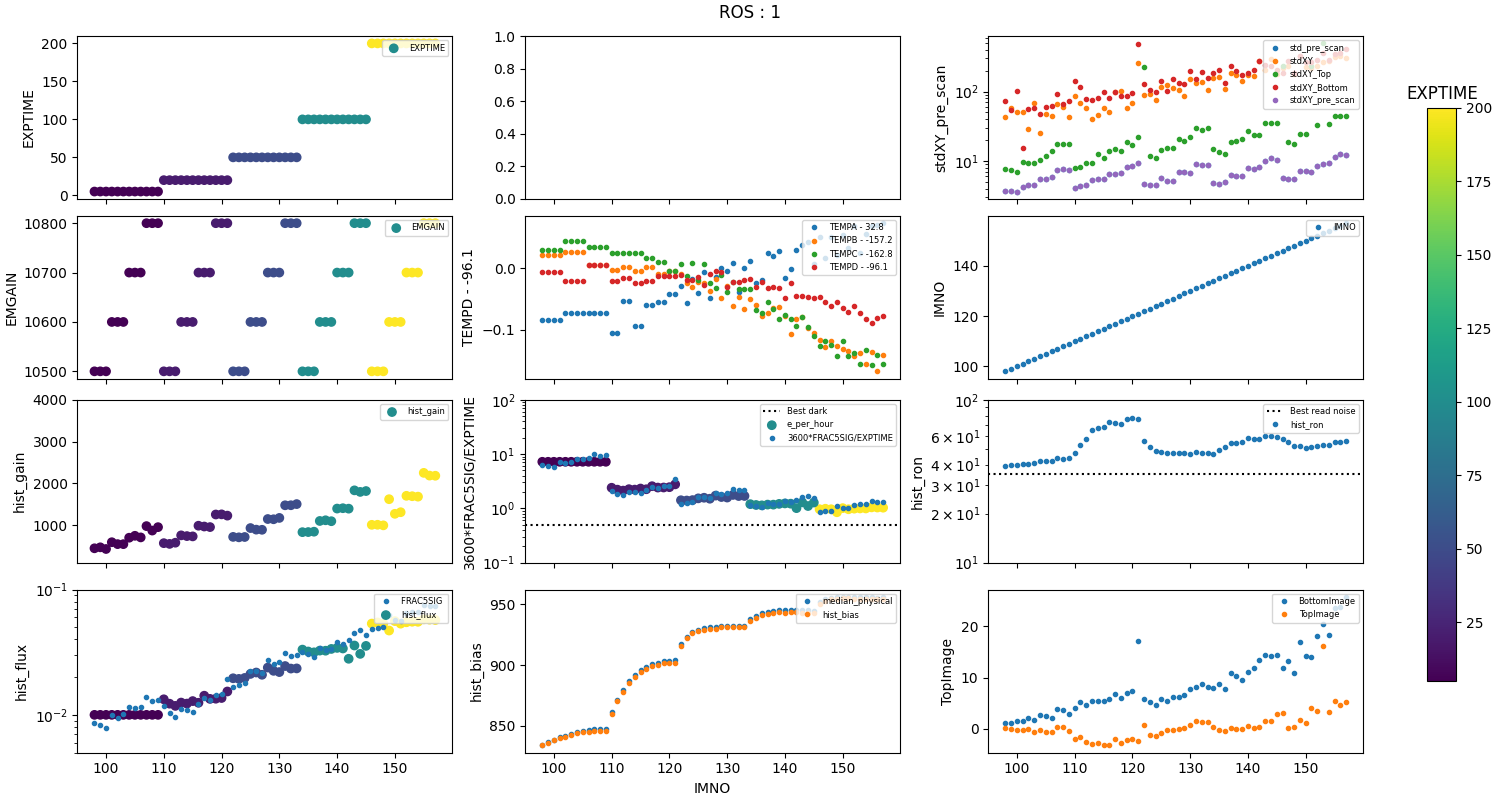

In [136]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.table import Table
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
import ipywidgets as widgets
import numpy as np
from scipy import interpolate
from datetime import datetime



# x = "SECONDS_TU"
# x = "Mins_after_launch"

# for col in ["EMGAIN","N_CR","EXPTIME"]:
#     cat[col.lower()] = interpolate.interp1d(cat[x][cat["IMNO"]>1], cat[col][cat["IMNO"]>1], kind="nearest",fill_value="extrapolate")(cat[x])


def add_line(cat, y, ax, x,i=0, init=True,l=None,style='None',display=True, change=False, ylabel=None,log=False,ylim=None, c=None,fig=None,**kwargs):
    if ylabel is None:
        ylabel = y
    if display == False:
        label = None
    else:
        try:
            label = ylabel#.replace(" * 1","") + " = %.5s"%(cat.eval(y)[i])
        except KeyError as e:
            label = None#ylabel
    # print(label)
    if init:
        # if log:
        #     if display==False: 
        #         l = ax.semilogy(cat.eval(x),cat.eval(y),'none', **kwargs)
        #     else:
        #         l = ax.semilogy(cat.eval(x),cat.eval(y),".", **kwargs)
        # else:
        if display==False: 
            l = ax.scatter(cat.eval(x),cat.eval(y),c=cat.eval(c),ls='none',label=label, **kwargs)
            # l = ax.plot(cat.eval(x),cat.eval(y),'none', **kwargs)
        else:
            if c is not None:
                l = ax.scatter(cat.eval(x),cat.eval(y),c=cat.eval(c),ls=style,label=label, **kwargs)
                # fig.colorbar(l, ax=ax)
            else:
                l = ax.plot(cat.eval(x),cat.eval(y),".", **kwargs)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)      
    if change:
        l[0].set_data(cat.eval(x),cat.eval(y))
        if display==False:
            l[0].set_linestyle('none')
        else:
            l[0].set_linestyle(style.replace(".","").replace("o",""))
    try:
        l[0].set_label(label)
    except TypeError:
        pass 
    if label is not None:
        ax.legend(loc="upper right", fontsize=6)
    return l


style={}#{'description_width': 'initial'} 
width = '400px'
continuous_update=True


# Bruits
# 1. RN
# 2. CIC
# 3. dark? / sky
# 4. gain / gain sans smearing
# 5. smearing
# Temperatures:
# 1. CR/t (avec % image lost)
# 2. temperatures
# Parametre
# 1. DAQ
# 2. Exptime
# 3. Readout sequence?
# Reduction:
# 1. Flux dans les fentes
# 2. stack?


# from datetime import datetime
# plt.figure()
# plt.plot([datetime.strptime(i, "%Y-%m-%dT%H:%M:%S") for i in cat["DATE"]],cat["IMNO"])
# plt.gcf().autofmt_xdate()
# plt.show()


class dashboard(widgets.HBox):
     
    def __init__(self,x,cat=cat,st="None",c="EXPTIME",ylim=0):
        super().__init__()
        self.output = widgets.Output()
        
        # self.ax1bis = self.ax1.twinx()

        self.fig, self.axes = plt.subplots(4,3, figsize=(15,8),sharex=True, constrained_layout=True)
        self.cat=cat
        (self.a0,self.a1,self.a2,self.a3) = self.axes
        a0, a1, a2, a3 = self.axes
        a3[1].set_xlabel(x)
        # a0[1].sharex(a0[0])
        # a0[0].get_shared_x_axes().join(a0[0],a0[1])
        self.la000 =  add_line(cat,"EXPTIME",x=x,ax=a0[0],style=st,display=True,c=c,fig=self.fig)
        self.la010 =  add_line(cat,"EMGAIN",x=x,ax=a1[0],style=st,display=True,c=c,fig=self.fig)


        # self.la100 = add_line(cat,"FRAC5SIG ",ax=a0[1],style=st,display=True,log=True,fig=self.fig)


        # self.la100 = add_line(cat,"N_CR",ax=a0[1],style=st,display=True,log=True,fig=self.fig)
        # self.la101= add_line(cat,y="MASK",x=x,ax=a3[1],style=st,display=True,fig=self.fig)


        # self.la310 = add_line(cat,y="hist_flux",x="EXPTIME",ax=a3[1],style=st,display=True,fig=self.fig,c=c)
        self.la200=[]
        for col in cat.columns:
            if (("TEMP" in col)&(len(col)<7)):
                try:
                    self.la200.append(add_line(cat,"%s - %0.1f"%(col,np.mean(cat[col])),x=x,ax=a1[1],style=st,display=True,fig=self.fig))
                except TypeError:
                    pass
        self.la11 = add_line(cat,y="hist_gain",x=x,ax=a2[0],style=st,display=True,log=True,fig=self.fig,c=c)


        self.la101 = add_line(cat,"FRAC5SIG ",x=x,ax=a3[0],style=st,display=True,fig=self.fig)
        self.la30 = add_line(cat,"hist_flux",x=x,ax=a3[0],style=st,display=True,log=True,fig=self.fig,c=c)
        a3[0].set_yscale("log")
        

        self.la30 = add_line(cat,"median_physical",x=x,ax=a3[1],style=st,display=True,fig=self.fig)
        self.la30 = add_line(cat,"hist_bias",x=x,ax=a3[1],style=st,display=True,fig=self.fig)


        a2[1].axhline(0.5,ls=":",c="k",label="Best dark")
        self.la210 = add_line(cat,y="e_per_hour",x=x,ax=a2[1],style=st,display=True,fig=self.fig,c=c)
        self.la211 = add_line(cat,y="3600*FRAC5SIG/EXPTIME",x=x,ax=a2[1],style=st,display=True,fig=self.fig)
        a2[1].set_yscale("log")
        self.la320 = add_line(cat,y="BottomImage",x=x,ax=a3[2],style=st,display=True,fig=self.fig)
        self.la321 = add_line(cat,y="TopImage",x=x,ax=a3[2],style=st,display=True,fig=self.fig)
        # a3[2].set_yscale("log")
        # self.la322 = add_line(cat,y="LINCENC",ax=a3[2],style='-',display=True,ylabel="LIN ENC")
        self.la020 = add_line(cat,"std_pre_scan",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
        self.la021 = add_line(cat,"stdXY",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
        self.la022 = add_line(cat,"stdXY_Top",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
        self.la023 = add_line(cat,"stdXY_Bottom",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
        self.la024 = add_line(cat,"stdXY_pre_scan",x=x,ax=a0[2],style=st,display=True,log=True,fig=self.fig)
        a0[2].set_yscale("log")
        self.la120 = add_line(cat,"IMNO",x=x,ax=a1[2],style='-',display=True)
        # self.la121 = add_line(cat,"Moon_El",ax=a1[2],style='-',display=True)
        # self.la122 = add_line(cat,"Sun_El",ax=a1[2],style='-',display=True)
        # self.la123 = add_line(cat,"F2_El",ax=a1[2],style='-',display=True)
        # self.la124 = add_line(cat,"m31_El",ax=a1[2],style='-',display=True, ylabel="Elevation")
        a2[2].axhline(35,ls=":",c="k",label="Best read noise")
        self.la22 = add_line(cat,"hist_ron",x=x,ax=a2[2],style=st,display=True,fig=self.fig)
        a2[2].set_yscale("log")
        # cbar = self.fig.colorbar(self.la210, orientation="horizontal",aspect=100,anchor=(1,0))
        # self.fig.subplots_adjust(right=0.95)
        # cbar = self.fig.colorbar(self.la210, cax=self.fig.add_axes([0.99, 0.05, 0.02, 0.9]))
        cbar = self.fig.colorbar(self.la210, ax=self.axes.ravel().tolist(), shrink=0.8,aspect=20)
        cbar.ax.set_title(c)
        if ylim ==100:
            a2[0].set_ylim((100,4000))
            a2[1].set_ylim((0.1,100))
            a2[2].set_ylim((10,100))
            a3[0].set_ylim((0.005,0.1))
            # a3[1].set_ylim((0,0.1))


        # for axes in self.axes:
        #     for ax in axes:
        #         ax.legend()
        # self.vlines = []
        # for axes in self.axes:
        #     for ax in axes:
        #         line = ax.axvline(x=cat[x][0], color="black", ls='--')
        #         self.vlines.append(line)

        # self.fig.tight_layout()
        # self.fig.constrained_layout()

        self.scatters = [self.la000,self.la010]
        self.fig.suptitle("ROS : %i"%(np.unique(cat["ROS"])))
    #     self.t = widgets.IntSlider( min=0, max=len(cat),value=0, style = style, layout=Layout(width=width),description='t',continuous_update=continuous_update,tooltip="t")
    #     self.temps = widgets.SelectMultiple(options=[col for col in cat.columns if (("TEMP" in col)&(len(col)<7))],value=[col for col in cat.columns if (("TEMP" in col)&(len(col)<7))],rows=3,description='Temps',disabled=False)
    #     self.x =  widgets.Dropdown(options=["IMNO", "DATE","Mins","Seconds"],value=x,description='x axis',disabled=False)
    #     self.y =  widgets.Dropdown(options=["value", "value/exptime"],value="value",description='y axis',disabled=False)
    #     self.query = widgets.Combobox(options=["IMNO>0 & Mins>50"], layout=Layout(width='350px'),description='Query',value="IMNO>0",continuous_update=False)
    #     self.color =  widgets.Dropdown(options=["EXPTIME","EMGAIN","IMNO", "DATE"],value="EXPTIME",description='Color',disabled=False)
    #     # self.style=widgets.Dropdown(options=['-', '--o', '-.', ':', 'None', ' ', ''],value="-",rows=1,description='style',disabled=False)
    #     # self.targets = widgets.SelectMultiple(options=["Moon", 'Sun', 'F2',"m31"],value=["Moon", 'Sun', 'F2',"m31"],rows=4,description='Targets',disabled=False)
    #     # self.GS = widgets.SelectMultiple(options=[0, 1, 2, 3, 4, 5 ,6 ,7],value=[0, 1, 2],rows=4,description='GS',disabled=False)
    #     # self.xlim = widgets.Select(options=["all", 'flight', 'UV',"F2"],value="all",rows=5,description='Temps',disabled=False)
    #     wids = widgets.interactive(self.update,t=self.t,temps=self.temps,x=self.x,y=self.y,query=self.query,color=self.color)#,style=self.style)#,targets=self.targets,xlim=self.xlim,GS=self.GS)
    #     # controls = VBox([HBox([self.t,self.temps, self.x, self.y]),   HBox([self.query,self.color]) ] ) #,self.targets,self.xlim,self.GS #,self.style
    #     controls = VBox([HBox([self.temps, self.x,self.query,self.color]) ] ) #,self.targets,self.xlim,self.GS #,self.style

    #     display(HBox([self.output,controls]))

        


    # def update(self,t,temps,x,y,query, color, style="."): #,targets,xlim,GS
    #     """Draw line in plot"""
        
    #     with self.output:
    #         a0, a1, a2, a3 = self.axes
    #         for scat in self.scatters:
    #             scat.set_array(cat[color])
    #         a0[2].relim()
    #         a0[2].autoscale_view()
    #         a0[2].relim()
    #         a0[2].autoscale_view()
    #         self.fig.canvas.draw()
    #         self.axes = a0, a1, a2, a3 
    #         return 


# cat = Table.read("FlightPrincipalCatalog_v5_tronc.csv")#
# cat = Table.read("/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/Flight/dobc_data/180922/CosmicRayFree/HeaderCatalog.csv")#
cat = Table.read("/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/Flight/dobc_data/180922/CosmicRayFree/HeaderCatalogbasic_estimators_FIREBall.csv")#

cat = Table.read("/Users/Vincent/DS9QuickLookPlugIn/subsets/S2/HeaderCatalogbasic_estimators_FIREBall.csv")#
# cat = Table.read("/Users/Vincent/DS9QuickLookPlugIn/subsets/S2_hdr/HeaderCatalogbasic_estimators_FIREBall.csv")#

# cat = Table.read("/Users/Vincent/DS9QuickLookPlugIn/subsets/CIT_NUVU_m100_darks_2022/230713_17H24m07/HeaderCatalogbasic_estimators_FIREBall.csv")#
# cat = Table.read("/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/HeaderCatalogbasic_estimators_FIREBall.csv")#

cat["DATE"] = [datetime.strptime(i, "%Y-%m-%dT%H:%M:%S") for i in cat["DATE"]]
cat["Mins"]= [(line["DATE"]-cat["DATE"][np.argmin(cat["DATE"])]).seconds/60 for line in cat]
cat["Seconds"]= [(line["DATE"]-cat["DATE"][np.argmin(cat["DATE"])]).seconds for line in cat]


if  'N_CR' not in cat.colnames:
    cat['N_CR']=np.nan
if  'MASK' not in cat.colnames:
    cat['MASK']=np.nan
# for c in cat.colnames:
#     cat.rename_column(c,c.replace(" ","_").split("[")[0])
cat = cat.to_pandas()

d = dashboard(cat=cat.query("EXPTIME>0 & IMNO>20"),x="IMNO",c="EXPTIME",ylim=100)#IMNO & Mins>50
# add log for GS Flux

In [34]:
# TODO ajouter axis double en y
# TODO ajouter possibilité de changer axis x
# TODO ajouter possibilité de mettre une filtre
# TODO ajouter smearing, flux in slits (to be selected, etc)
# TODO ajouter valeurs usuelles
# TODO ajouter danc chaque image quel masque c'est 

150

In [121]:
cat = Table.read("/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/HeaderCatalogbasic_estimators_FIREBall.csv")#


In [122]:
cat

Index,Filename,Directory,IMNO_1,ModificationTime,FileSize_Mo,CreationTime,CreationTime_ISO8601,dir_path,SIMPLE,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,BZERO,BSCALE,ADD_COMM,IMG_SIZE,SOFT_VER,DATE,EXPTIME,EMGAIN,GAIN1,VSS,IMNO,IMBURST,SHUTTER,ROS,CDSOFFSET,TEMPDATE,TEMPTIME,TEMPA,TEMPB,OBSTYPE,median_physical,mean_physical,Col2ColDiff_pre_scan,Line2lineDiff_pre_scan,SaturatedPixels,median_pre_scan,mean_pre_scan,std_pre_scan,stdXY,stdXY_Top,stdXY_Bottom,stdXY_pre_scan,BottomImage,TopImage,BottomImage_median,TopImage_median,flat,percentile_04,percentile_998,hist_bias,hist_ron,hist_gain,hist_flux,e_per_hour,FRAC5SIG,Path
int64,str16,str13,int64,float64,float64,float64,str19,str115,str4,int64,int64,int64,int64,str4,int64,int64,int64,str9,str5,str19,float64,int64,float64,int64,int64,int64,int64,int64,int64,int64,str4,str4,str4,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str132
0,image000046.fits,EXPTIME_100.0,46,230627.2025,13.31,230627.2025,2023-06-27T20:25:38,/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/Directory_dark_05272023_g1000_minus90/EXPTIME_100.0,True,16,2,3216,2069,True,32768,1,--,"3216,2069",4.2.1,2023-05-28T00:38:37,100.0,8243,0.0,0,46,5,0,2,500,--,""",",$.7,X!.7,OBJECT,7820.905787078271,7851.344694951665,0.003383276945896796,0.32000000000061846,0.0031686358754027927,7819.0,7822.8599722087965,101.12437462862336,442.850889419344,251.4081598880566,338.16097079192554,101.12437462862336,18.425712114632915,29.88438775510167,-6.0,3.0,5.0989993605181165e-06,7743.0,10884.0,7821.020000000046,17.527434779083144,1452.8070054807533,0.01785318746254706,0.6427147486516941,0.027540472253294007,/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/Directory_dark_05272023_g1000_minus90/EXPTIME_100.0/image000046.fits
1,image000047.fits,EXPTIME_100.0,47,230627.2025,13.31,230627.2025,2023-06-27T20:25:38,/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/Directory_dark_05272023_g1000_minus90/EXPTIME_100.0,True,16,2,3216,2069,True,32768,1,--,"3216,2069",4.2.1,2023-05-28T00:40:17,100.0,8243,0.0,0,47,5,0,2,500,--,""",",$.7,X!.7,OBJECT,7826.980280034644,7853.929236842106,0.23682938617821492,0.04874999999992724,0.0024704618689581096,7826.0,7829.448597148381,108.36363943214668,406.5420635871798,256.47155145802435,445.8806634817404,108.36363943214668,18.91440512375175,26.876377551020596,-7.0,2.0,0.0,7742.0,10792.002000000095,7828.060000000047,17.63564784261606,1504.9356327805792,0.01442588783614254,0.5193319621011314,0.024279590817726668,/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/Directory_dark_05272023_g1000_minus90/EXPTIME_100.0/image000047.fits
2,image000048.fits,EXPTIME_100.0,48,230627.2025,13.31,230627.2025,2023-06-27T20:25:38,/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/Directory_dark_05272023_g1000_minus90/EXPTIME_100.0,True,16,2,3216,2069,True,32768,1,--,"3216,2069",4.2.1,2023-05-28T00:41:57,100.0,8243,0.0,0,48,5,0,2,500,--,""",",$.7,X!.7,OBJECT,7825.264512338587,7850.000655746509,0.45819236346142134,0.2787500000004002,0.0017722878625134263,7824.0,7827.789232721121,106.4430498192556,374.94307612367277,257.97435105459266,317.2581590101046,106.4430498192556,15.364142422926307,24.07994897959179,-6.0,2.0,7.113270493497338e-06,7731.0,10623.002000000095,7826.060000000041,17.550339386854155,1409.1725311928813,0.013964181649327766,0.5027105393757996,0.02311190997212989,/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/Directory_dark_05272023_g1000_minus90/EXPTIME_100.0/image000048.fits
3,image000056.fits,EXPTIME_150.0,56,230627.2025,13.31,230627.2025,2023-06-27T20:25:38,/Users/Vincent/DS9QuickLookPlugIn/subsets/230627_UA_darks/Directory_dark_05272023_g1000_minus90/EXPTIME_150.0,True,16,2,3216,2069,True,32768,1,--,"3216,2069",4.2.1,2023-05-28T00:48:42,150.0,8243,0.0,0,56,5,0,2,500,--,""",",$.7,X!.7,OBJECT,7826.172063064732,7863.871218582

Todo:
- put all orders (temperatures, az/el, guiding stars positions)
- add electric consumption?
- add new temperatures
- change to dates x abs
- add some tracer with t
- add BRD-VM_30MS_1-TM-MISSION1-Batterie

In [133]:


        # with self.output:
        #     a0, a1, a2, a3 = self.axes

        

        # # self.vlines = []
        #     for line in  self.vlines:
        #         line.set_xdata(self.cat[self.x.value][t])
        #     # if xlim == "all":
        #     #     for a in a0:
        #     #         a.set_xlim((np.nanmin(cat[x]),np.nanmax(cat[x])))
        #     # elif xlim=="flight":
        #     #     for a in a0:
        #     #         a.set_xlim((50,150))
        #     # elif xlim=="F2":
        #     #     for a in a0:
        #     #         a.set_xlim((600,680))
        #     # elif xlim== "UV":
        #     #     for a in a0:
        #     #         a.set_xlim((500,850))
        #     add_line(cat,"EXPTIME",ax=a0[0],i=t,x=self.x.value, init=False,l= self.la000 ,style=style,display=True ,change=True)
        #     add_line(cat,"EMGAIN",ax=a1[0],i=t, x=self.x.value,init=False,l= self.la010 ,style=style,display=True,change=True)
        #     add_line(cat,"N_CR",ax=a0[1],i=t, x=self.x.value,init=False, l=self.la100,style=style,display=True, change=True)
        #     # i=0
        #     # for col in cat.columns:
        #     #     if (("TEMP" in col)&(len(col)<7)):
        #     #         i+=1
        #     #         # self.la200.append(add_line(cat,col,ax=a2[0],style=st,display=True))
        #     #         add_line(cat,col,ax=a2[0],i=t, init=False,l= self.la200[i],style=style,display=True, change=True)
        #     # add_line(cat,"Reject",ax=a2[0],i=t, init=False, l=self.la201,style='-',display=True if "Reject" in temps else False,change=True)
        #     # add_line(cat,"Coldhead",ax=a2[0],i=t, init=False, l=self.la202,style='-',display=True if "Coldhead" in temps else False, change=True)
        #     a2[0].relim()
        #     a2[0].autoscale_view()

        #     add_line(cat,"median_physical",ax=a3[0],x=self.x.value,i=t,init=False,l=self.la30,style=style,display=True,change=True)
        #     add_line(cat,"MASK",ax=a3[1],i=t, x=self.x.value,init=False, l=self.la310,style=style,display=True,change=True)
        #     add_line(cat,"e_per_hour",ax=a2[1],i=t, x=self.x.value,init=False, l=self.la21,style=style,display=True,change=True)
        #     add_line(cat,"hist_gain",ax=a1[1],i=t,x=self.x.value, init=False, l=self.la11,style=style,display=True,change=True)
        #     add_line(cat,"BottomImage",ax=a3[2],i=t, x=self.x.value,init=False, l=self.la320,style=style,display=True,change=True)
        #     add_line(cat,"TopImage",ax=a3[2],i=t, x=self.x.value,init=False, l=self.la321,style=style,display=True,change=True)
        #     # add_line(cat,"LINCENC",ax=a3[2],i=t, init=False, l=self.la322,style='-',display=True)
                
        #     add_line(cat,"std_pre_scan",ax=a0[2],i=t, x=self.x.value,init=False, l=self.la020,style=style,display=True,change=True)
        #     add_line(cat,"stdXY",ax=a0[2],i=t,x=self.x.value, init=False, l=self.la021,style=style,change=True)
        #     add_line(cat,"stdXY_Top",ax=a0[2],i=t, x=self.x.value,init=False, l=self.la022,style=style,change=True)
        #     add_line(cat,"stdXY_Bottom",ax=a0[2],i=t, x=self.x.value,init=False, l=self.la023,style=style,change=True)
        #     add_line(cat,"stdXY_pre_scan",ax=a0[2],i=t, x=self.x.value,init=False, l=self.la024,style=style,change=True)
        #     a0[2].relim()
        #     a0[2].autoscale_view()

        #     # add_line(cat,"EL",ax=a1[2],i=t, init=False, l=self.la120,style='-',display=True)
        #     # add_line(cat,"Moon_El",ax=a1[2],i=t, init=False, l=self.la121,style='-',display=True if "Moon" in targets else False, change=True)
        #     # add_line(cat,"Sun_El",ax=a1[2],i=t, init=False, l=self.la122,style='-',display=True if "Sun" in targets else False, change=True)
        #     # add_line(cat,"F2_El",ax=a1[2],i=t, init=False, l=self.la123,style='-',display=True if "F2" in targets else False, change=True)
        #     # add_line(cat,"m31_El",ax=a1[2],i=t, init=False, l=self.la124,style='-',display=True if "m31" in targets else False, change=True)
        #     a0[2].relim()
        #     a0[2].autoscale_view()
        #     add_line(cat,"hist_ron",ax=a2[2],i=t, x=self.x.value,init=False, l=self.la22, style=style,display=True,change=True)
        #     self.fig.canvas.draw()
        #     self.axes = a0, a1, a2, a3 
        #     return 
        #     # fitswrite(self.im, "/tmp/test_%s.fits"%(fwhm[1]))
